In [1]:
import numpy as np
import torch
import networkx as nx
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
from src.CBN import CausalBayesianNetwork as CBN
import modularised_utils as mut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import evaluation_utils as evut
import params
from cmnist_utils import CMNISTLinearSCM
import torchvision
import random
import joblib

import opt_utils as oput

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
resolution = 32
correlation = 0.85

experiment_map = {
    2: 'cm2f2',
    4: 'cm4f2',
    8: 'cm8f2',
    16: 'cm16f2',
    32: 'cm32f2'
}

experiment = experiment_map.get(resolution)

In [3]:
Dll_obs = joblib.load(f"data/{experiment}/Dll_obs_test.pkl")
Dhl_obs = joblib.load(f"data/{experiment}/Dhl_obs_test.pkl")

ll_causal_graph, Ill_relevant = joblib.load(f"data/{experiment}/LL.pkl")
hl_causal_graph, Ihl_relevant= joblib.load(f"data/{experiment}/HL.pkl")

ll_endogenous_coeff_dict = joblib.load(f"data/{experiment}/ll_endogenous_coeff_dict.pkl")
hl_endogenous_coeff_dict = joblib.load(f"data/{experiment}/hl_endogenous_coeff_dict.pkl")

omega = joblib.load(f"data/{experiment}/omega.pkl")

det_ll_dict = joblib.load(f"data/{experiment}/det_ll_dict.pkl")
det_hl_dict = joblib.load(f"data/{experiment}/det_hl_dict.pkl")

T_results_emp = joblib.load(f"data/{experiment}/diroca_train_results_empirical.pkl")

In [4]:
def get_ll_coefficients(data, img_dim=None, n_channels=3, use_ridge=False, alpha=1.0):
    """
    For each channel (R, G, B), fit a linear regression to predict pixel values using:
      - One-hot digit (10 features)
      - One-hot color (10 features)
      - x-coordinate (1 feature)
      - y-coordinate (1 feature)
    Returns:
      - coeffs: dict mapping channel index to regression coefficients (length 22)
      - residuals: dict mapping channel index to residuals (1D array, one per pixel sample)
    """
    img_size = data.shape[1] - 20
    if img_dim is None:
        img_dim = int(np.sqrt(img_size / n_channels))
    
    digit_onehot = data[:, img_size:img_size+10]
    color_onehot = data[:, img_size+10:img_size+20]
    
    n_samples = data.shape[0]
    coeffs = {}
    residuals = {}

    for channel in range(n_channels):
        X_list = []
        y_list = []
        for i in range(n_samples):
            img_flat = data[i, :img_size]
            img = img_flat.reshape((img_dim, img_dim, n_channels))
            for x in range(img_dim):
                for y in range(img_dim):
                    # Predictors: [digit_onehot, color_onehot, x, y]
                    predictors = np.concatenate([
                        digit_onehot[i],         # shape (10,)
                        color_onehot[i],         # shape (10,)
                        [x], [y]                 # shape (2,)
                    ])
                    X_list.append(predictors)
                    y_list.append(img[x, y, channel])
        X = np.vstack(X_list)  # shape: (n_samples * img_dim * img_dim, 22)
        y = np.array(y_list)   # shape: (n_samples * img_dim * img_dim,)

        model = Ridge(alpha=alpha) if use_ridge else LinearRegression()
        model.fit(X, y)
        coeffs[channel] = model.coef_  # shape: (22,)
        residuals[channel] = y - model.predict(X)  # shape: (n_samples * img_dim * img_dim,)
        #residuals[channel] = (y - model.predict(X))**2

    return coeffs, residuals

def get_hl_coefficients(data, use_ridge=False, alpha=1.0):
    """
    For the high-level data (aggregated image), fit a linear regression to predict
    the aggregated image value using:
      - One-hot digit (9 features, drop last to avoid singularity)
      - One-hot color (9 features, drop last to avoid singularity)
    Returns:
      - coeffs: 1D numpy array of regression coefficients (length 18)
      - residuals: 1D array of residuals (noise) for the high-level image variable
    """
    D = data[:, :10][:, :-1]  # Use only first 9 columns
    C = data[:, 10:20][:, :-1]  # Use only first 9 columns
    I = data[:, 20]
    X = np.column_stack((D, C))  # shape: (n_samples, 18)
    y = I
    model = Ridge(alpha=alpha) if use_ridge else LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    coeffs = model.coef_  # shape: (18,)
    return coeffs, residuals

In [5]:
ll_coeffs, ll_residuals = get_ll_coefficients(Dll_obs)
hl_coeffs, hl_residuals = get_hl_coefficients(Dhl_obs)

In [6]:
# For low-level: concatenate all residuals for all images and all channels
U_L = np.column_stack([
    ll_residuals[0],  # shape: (N * img_dim * img_dim,)
    ll_residuals[1],
    ll_residuals[2]
])  # shape: (N * img_dim * img_dim, 3)

# If you want shape (N, 3072), reshape accordingly:
N = Dll_obs.shape[0]
img_dim = 32
n_pixels = img_dim * img_dim
U_L = U_L.reshape(N, n_pixels * 3)  # shape: (N, 3072)

# For high-level: all residuals for all images
U_H = hl_residuals.reshape(-1, 1)  # shape: (N, 1)

In [7]:
def generate_perturbation_family(center_matrix, k, r_mu, r_sigma, direction, mean_shift, coverage, seed=None):
    """
    Generate k perturbation matrices with option for uniform coverage.

    Args:
        center_matrix: Base matrix to perturb (n, m)
        k: Number of perturbations to generate
        r_mu: Max norm of mean shifts (random direction component)
        r_sigma: Max Frobenius norm of covariance shifts
        direction: If True, use random direction for mean shift; if False, only use mean_shift
        mean_shift: Value to add as a global mean shift to all elements
        coverage: Either 'rand' (original) or 'uniform' for better ball coverage
        seed: Optional random seed

    Returns:
        List of perturbation matrices
    """
    if seed is not None:
        np.random.seed(seed)

    n, m = center_matrix.shape
    total_dims = n * m  # Total dimensionality for uniform sampling
    perturbations = []

    for i in range(k):
        if coverage == 'rand':
            A = np.random.randn(n, m)
            A = r_sigma * A / np.linalg.norm(A, ord='fro')

            if direction and r_mu > 0:
                delta_mu = np.random.randn(n, m)
                delta_mu = r_mu * delta_mu / np.linalg.norm(delta_mu)
            else:
                delta_mu = np.zeros((n, m))
                delta_mu += mean_shift

        elif coverage == 'uniform':
            A = np.random.randn(n, m)
            A_norm = np.linalg.norm(A, ord='fro')
            A = A / A_norm
            
            u_sigma = np.random.random()
            r_sigma_actual = r_sigma * u_sigma**(1.0/total_dims)
            A = r_sigma_actual * A

            if direction and r_mu > 0:
                delta_mu = np.random.randn(n, m)
                mu_norm = np.linalg.norm(delta_mu, ord='fro')
                delta_mu = delta_mu / mu_norm
                u_mu = np.random.random()
                r_mu_actual = r_mu * u_mu**(1.0/total_dims)
                delta_mu = r_mu_actual * delta_mu
            else:
                delta_mu = np.zeros((n, m))
                delta_mu += mean_shift

        else:
            raise ValueError(f"Unknown coverage type: {coverage}. Use 'rand' or 'uniform'")

        perturbation = A + delta_mu
        perturbations.append(perturbation)

    return perturbations

In [8]:
def compute_errors_new(
    T_results_emp,
    Ill_relevant,
    det_ll_dict,
    det_hl_dict,
    digit_onehotL,
    color_onehotL,
    digit_onehotH,
    color_onehotH,
    omega,
    base_noise_L,    # shape: (N, 3072)
    base_noise_H,    # shape: (N, 1)
    shift=False,
    r_mu=.5,
    r_sigma=0.0,
    mean_shift=0.0,
    direction=True,
    num_perturbations=1,
    coverage_type='rand'
):
    if shift:
        # Generate perturbations for noise
        pert_family_L = generate_perturbation_family(
            np.zeros_like(base_noise_L),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            mean_shift=mean_shift,
            direction=direction,
            coverage=coverage_type
        )
        pert_family_H = generate_perturbation_family(
            np.zeros_like(base_noise_H),
            k=num_perturbations,
            r_mu=r_mu,
            r_sigma=r_sigma,
            mean_shift=mean_shift,
            direction=direction,
            coverage=coverage_type
        )
    else:
        # No perturbations, only one "fake" no-perturbation
        pert_family_L = [np.zeros_like(base_noise_L)]
        pert_family_H = [np.zeros_like(base_noise_H)]
        num_perturbations = 1

    # Initialize result dictionary
    results = {method: [] for method in T_results_emp.keys()}

    # Convert deterministic parts to torch tensors if they aren't already
    det_ll_dict = {k: torch.as_tensor(v, dtype=torch.float32) if not torch.is_tensor(v) else v 
                   for k, v in det_ll_dict.items()}
    det_hl_dict = {k: torch.as_tensor(v, dtype=torch.float32) if not torch.is_tensor(v) else v 
                   for k, v in det_hl_dict.items()}
    
    for pert_L, pert_H in zip(pert_family_L, pert_family_H):
        for method_name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            distances = []
            #if method_name not in ['T_pa', 'T_na']:
            for iota in Ill_relevant:
                # Get deterministic parts for this intervention
                det_ll = det_ll_dict[iota]
                det_hl = det_hl_dict[omega[iota]]

                if shift:
                    endo_ll = det_ll + torch.tensor(base_noise_L + pert_L, dtype=torch.float32)
                    #endo_ll = torch.clamp(endo_ll, 0, 1)
                    endo_ll = endo_ll - endo_ll.min()
                    endo_ll = endo_ll / (endo_ll.max() + 1e-8)
                    endo_ll_full = torch.cat([
                                                endo_ll, 
                                                torch.tensor(digit_onehotL, dtype=endo_ll.dtype, device=endo_ll.device),
                                                torch.tensor(color_onehotL, dtype=endo_ll.dtype, device=endo_ll.device)
                                            ], dim=1)
                    
                    endo_hl = det_hl + torch.tensor(base_noise_H + pert_H, dtype=torch.float32)
                    #endo_hl = torch.clamp(endo_hl, 0, 1)
                    endo_hl = endo_hl - endo_hl.min()
                    endo_hl = endo_hl / (endo_hl.max() + 1e-8)
                    endo_hl_full = torch.cat([
                                                endo_hl,
                                                torch.tensor(digit_onehotH, dtype=endo_hl.dtype, device=endo_hl.device),
                                                torch.tensor(color_onehotH, dtype=endo_hl.dtype, device=endo_hl.device)
                                            ], dim=1)
                else:
                    endo_ll = det_ll + torch.tensor(base_noise_L, dtype=torch.float32)
                    #endo_ll = torch.clamp(endo_ll, 0, 1)
                    endo_ll = endo_ll - endo_ll.min()
                    endo_ll = endo_ll / (endo_ll.max() + 1e-8)
                    endo_ll_full = torch.cat([
                                                endo_ll, 
                                                torch.tensor(digit_onehotL, dtype=endo_ll.dtype, device=endo_ll.device),
                                                torch.tensor(color_onehotL, dtype=endo_ll.dtype, device=endo_ll.device)
                                            ], dim=1) 
                    
                    endo_hl = det_hl + torch.tensor(base_noise_H, dtype=torch.float32)
                    #endo_hl = torch.clamp(endo_hl, 0, 1)
                    endo_hl = endo_hl - endo_hl.min()
                    endo_hl = endo_hl / (endo_hl.max() + 1e-8)
                    endo_hl_full = torch.cat([
                                                endo_hl,
                                                torch.tensor(digit_onehotH, dtype=endo_hl.dtype, device=endo_hl.device),
                                                torch.tensor(color_onehotH, dtype=endo_hl.dtype, device=endo_hl.device)
                                            ], dim=1)
    
                # Project low-level to high-level
                T_tensor = torch.tensor(T, dtype=torch.float32)
                mapped_ll = (T_tensor @ endo_ll_full.T).T

                # Compute distance
                dist = evut.compute_empirical_distance(mapped_ll.detach().numpy(), 
                                                    endo_hl_full.detach().numpy(), 'fro')
                distances.append(dist)

            results[method_name].extend(distances)

    return results

In [9]:
# # Pick a sample noise vector (e.g., the first row of U_L)
# base_noise = U_L[7]  # shape (3072,)

# # Generate perturbations
# mean_shift_val = 1
# r_sigma_val = 2.0

# # Pure mean shift
# pert_mean = np.ones_like(base_noise) * mean_shift_val

# # Pure covariance shift
# pert_cov = np.random.randn(*base_noise.shape)
# pert_cov = r_sigma_val * pert_cov / np.linalg.norm(pert_cov) * np.linalg.norm(base_noise)

# # Both together
# pert_both = pert_mean + pert_cov

# # Visualize as images
# def show_image(vec, title):
#     img = vec.reshape(32, 32, 3)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(title)

# plt.figure(figsize=(12, 3))
# plt.subplot(1, 4, 1)
# show_image(base_noise, "Original Noise")
# plt.subplot(1, 4, 2)
# show_image(base_noise + pert_mean, "Mean Shift")
# plt.subplot(1, 4, 3)
# show_image(base_noise + pert_cov, "Covariance Shift")
# plt.subplot(1, 4, 4)
# show_image(base_noise + pert_both, "Mean + Covariance Shift")
# plt.tight_layout()
# plt.show()

In [10]:
def det_ll_func(parent_info_ll, iota):
    # parent_info_ll: dict with keys 'digit_onehot', 'color_onehot', 'x', 'y', 'coeffs'
    # iota: intervention (can be None)
    digit_onehot = parent_info_ll['digit_onehot'].copy()  # Add copy
    color_onehot = parent_info_ll['color_onehot'].copy()  # Add copy
    x_coords = parent_info_ll['x']
    y_coords = parent_info_ll['y']
    coeffs = parent_info_ll['coeffs']  # dict: channel -> 22-dim vector

    # Add intervention handling
    if iota is not None:
        intervention_dict = iota.vv()
        if 'digit' in intervention_dict:
            digit_onehot = np.zeros_like(digit_onehot)
            digit_onehot[:, intervention_dict['digit']] = 1
        if 'color' in intervention_dict:
            color_onehot = np.zeros_like(color_onehot)
            color_onehot[:, intervention_dict['color']] = 1

    N = digit_onehot.shape[0]
    img_dim = len(x_coords)
    n_channels = len(coeffs)
    det = np.zeros((N, img_dim * img_dim * n_channels))
    for i in range(N):
        det_i = []
        for c in range(n_channels):
            det_img = []
            for x in range(img_dim):
                for y in range(img_dim):
                    predictors = np.concatenate([digit_onehot[i], color_onehot[i], [x], [y]])
                    det_img.append(np.dot(coeffs[c], predictors))
            det_i.append(det_img)
        det[i, :] = np.concatenate(det_i)
    return torch.tensor(det, dtype=torch.float32)

def det_hl_func(parent_info_hl, omega_iota):
    # parent_info_hl: dict with keys 'digit_onehot', 'color_onehot', 'coeffs'
    digit_onehot = parent_info_hl['digit_onehot'].copy()  # Add copy
    color_onehot = parent_info_hl['color_onehot'].copy()  # Add copy
    coeffs = parent_info_hl['coeffs']  # 1D array (length 18 or 20)

    # Add intervention handling
    if omega_iota is not None:
        intervention_dict = omega_iota.vv()
        if 'D_' in intervention_dict:
            digit_onehot = np.zeros_like(digit_onehot)
            digit_onehot[:, intervention_dict['D_']] = 1
        if 'C_' in intervention_dict:
            color_onehot = np.zeros_like(color_onehot)
            color_onehot[:, intervention_dict['C_']] = 1

    N = digit_onehot.shape[0]
    det = []
    for i in range(N):
        predictors = np.concatenate([digit_onehot[i][:-1], color_onehot[i][:-1]])  # drop last col if needed
        det.append(np.dot(coeffs, predictors))
    return torch.tensor(np.array(det).reshape(-1, 1), dtype=torch.float32)

In [11]:
# First, create parent info for test data
parent_info_ll_test = {
    'digit_onehot': Dll_obs[:, -20:-10],  # Using Dll_obs (test data)
    'color_onehot': Dll_obs[:, -10:],
    'x': np.arange(img_dim),
    'y': np.arange(img_dim),
    'coeffs': ll_coeffs
}

parent_info_hl_test = {
    'digit_onehot': Dhl_obs[:, :10],      # Using Dhl_obs (test data)
    'color_onehot': Dhl_obs[:, 10:20],
    'coeffs': hl_coeffs
}

# Compute deterministic parts for test data
det_ll_dict_test = {}
for iota in Ill_relevant:
    det_ll_dict_test[iota] = det_ll_func(parent_info_ll_test, iota)

det_hl_dict_test = {}
for eta in Ihl_relevant:
    det_hl_dict_test[eta] = det_hl_func(parent_info_hl_test, eta)

In [12]:
digit_onehotL = Dll_obs[:, 3072:3082]  # (N, 10)
color_onehotL = Dll_obs[:, 3082:3092]  # (N, 10)

digit_onehotH = Dhl_obs[:, :10]  # (N, 10)
color_onehotH = Dhl_obs[:, 10:20]  # (N, 10)

In [13]:
# Compute errors with no shift
results_no_shift = compute_errors_new(
    T_results_emp=T_results_emp,
    Ill_relevant=Ill_relevant,
    det_ll_dict=det_ll_dict_test,
    det_hl_dict=det_hl_dict_test,
    digit_onehotL=digit_onehotL,
    color_onehotL=color_onehotL,
    digit_onehotH=digit_onehotH,
    color_onehotH=color_onehotH,
    omega=omega,
    base_noise_L=U_L,  # Your noise from earlier
    base_noise_H=U_H,  # Your noise from earlier
    shift=False
)

In [14]:
# Compute errors with shift
results_with_shift = compute_errors_new(
    T_results_emp=T_results_emp,
    Ill_relevant=Ill_relevant,
    det_ll_dict=det_ll_dict_test,
    det_hl_dict=det_hl_dict_test,
    digit_onehotL=digit_onehotL,
    color_onehotL=color_onehotL,
    digit_onehotH=digit_onehotH,
    color_onehotH=color_onehotH,
    omega=omega,
    base_noise_L=U_L,
    base_noise_H=U_H,
    shift=True,
    r_mu=1,        # Adjust these parameters
    r_sigma=1,     # to control the shift
    mean_shift=0.0,
    num_perturbations=100
)

In [17]:
for shift_type in [results_no_shift, results_with_shift]:
    if shift_type == results_with_shift:
        print('\nDistribution Shift Analysis')
    else:
        print('\nNo Distribution Shift Analysis')
    
    print("=" * 100)
    
    method_stats = {}
    for method, errors in shift_type.items():
        mean = np.mean(errors)
        std = np.std(errors)
        if shift_type == results_with_shift:
            ci = std/10  # 95% confidence interval
        else:
            ci = std
        method_stats[method] = {
            'mean': mean,
            'std': std,
            'ci': ci
        }
        

    # Sort methods by mean error (ascending = better)
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1]['mean'])

    # Print results in a table format
    print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
    print("-" * 100)

    for method, stats in sorted_methods:
        print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")

    print("=" * 100)

    # Print best and worst methods
    best_method = min(method_stats.items(), key=lambda x: x[1]['mean'])
    worst_method = max(method_stats.items(), key=lambda x: x[1]['mean'])

    print(f"\nBest method: {best_method[0]} (error: {best_method[1]['mean']:.4f} ± {best_method[1]['ci']:.4f})")
    print(f"Worst method: {worst_method[0]} (error: {worst_method[1]['mean']:.4f} ± {worst_method[1]['ci']:.4f})")
    print(f"Error difference: {worst_method[1]['mean'] - best_method[1]['mean']:.4f}")


No Distribution Shift Analysis
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_0.188-0.188     6.5472 ± 0.2588  
T_1              11.4479 ± 0.1125  
T_4              14.0282 ± 0.1673  
T_8              15.8572 ± 0.1361  
T_2              18.1185 ± 0.2799  
T_na             23.5099 ± 0.1230  
T_pa             24.7109 ± 0.1254  
T_30             40.4263 ± 0.3643  
T_100            80.0140 ± 0.6389  
T_s             128.4695 ± 1.6557  
T_0.00          276.5453 ± 3.3824  
T_b             356.6461 ± 4.8545  

Best method: T_0.188-0.188 (error: 6.5472 ± 0.2588)
Worst method: T_b (error: 356.6461 ± 4.8545)
Error difference: 350.0989

Distribution Shift Analysis
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_0.188-0.188     6.6447 ± 0.0468  
T_1              11.5647 ± 0.0211  
T_4 

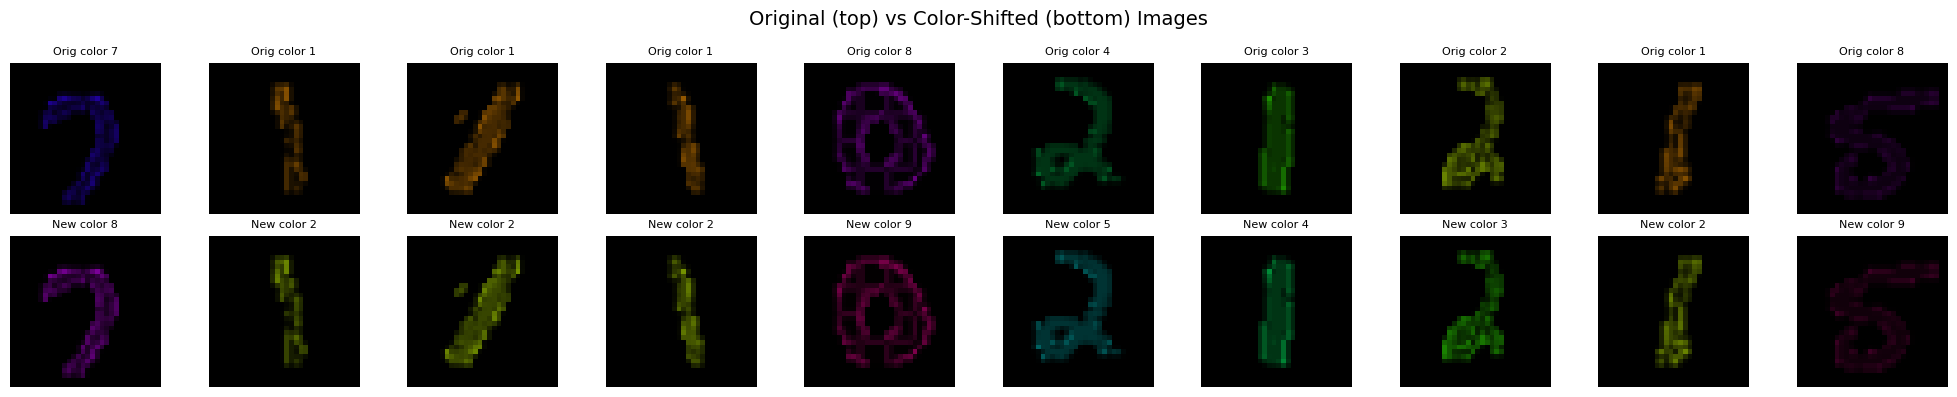

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Define color palette (10 distinct colors)
color_palette = np.array([
    (1.0, 0.0, 0.0),    # Red
    (1.0, 0.6, 0.0),    # Orange
    (0.8, 1.0, 0.0),    # Yellow-Green
    (0.2, 1.0, 0.0),    # Green
    (0.0, 1.0, 0.4),    # Blue-Green
    (0.0, 1.0, 1.0),    # Cyan
    (0.0, 0.4, 1.0),    # Light Blue
    (0.2, 0.0, 1.0),    # Blue
    (0.8, 0.0, 1.0),    # Purple
    (1.0, 0.0, 0.6)     # Pink
])

# Apply a color to a grayscale digit mask
def apply_color_to_digit(digit_img, color_onehot):
    if digit_img.ndim == 1:
        digit_img = digit_img.reshape(32, 32, 3)
    digit_mask = digit_img.mean(axis=2)  # grayscale intensity
    color_rgb = color_palette[np.argmax(color_onehot)]
    img_colored = np.zeros_like(digit_img)
    for c in range(3):
        img_colored[:, :, c] = digit_mask * color_rgb[c]
    return img_colored

# 1. Select batch of samples
K = 10
indices = np.arange(K)

# 2. Cyclically shift color one-hot encodings
original_colors = np.argmax(color_onehotL[indices], axis=1)
num_colors = color_onehotL.shape[1]
new_colors = (original_colors + 1) % num_colors

color_onehotL_shifted = color_onehotL.copy()
for idx, new_c in zip(indices, new_colors):
    color_onehotL_shifted[idx] = 0
    color_onehotL_shifted[idx, new_c] = 1

# 3. Visualize original vs shifted colored images
plt.figure(figsize=(2 * K, 4))
for idx, i in enumerate(indices):
    # Original
    plt.subplot(2, K, idx + 1)
    orig_img = Dll_obs[i, :3072].reshape(32, 32, 3)
    orig_colored = apply_color_to_digit(orig_img, color_onehotL[i])
    plt.imshow(np.clip(orig_colored, 0, 1))
    plt.axis('off')
    plt.title(f"Orig color {original_colors[idx]}", fontsize=8)

    # Shifted
    plt.subplot(2, K, K + idx + 1)
    shifted_colored = apply_color_to_digit(orig_img, color_onehotL_shifted[i])
    plt.imshow(np.clip(shifted_colored, 0, 1))
    plt.axis('off')
    plt.title(f"New color {new_colors[idx]}", fontsize=8)

plt.suptitle("Original (top) vs Color-Shifted (bottom) Images", fontsize=14)
plt.tight_layout()
plt.show()


In [91]:
import numpy as np

# Parameters
num_trials = 10
num_samples = int(np.floor(color_onehotL.shape[0] / 2))
num_colors = color_onehotL.shape[1]
original_colors = np.argmax(color_onehotL, axis=1)

# Storage for results across trials
method_errors = {}  # Dict: method -> list of trial means

for trial in range(num_trials):
    color_onehotL_combined = color_onehotL.copy()
    shuffled_indices = np.random.permutation(num_samples)

    for idx in range(num_samples):
        if np.random.rand() < 0.5:
            # Assign color from another randomly selected sample
            color_onehotL_combined[idx] = color_onehotL[shuffled_indices[idx]]
        else:
            # Assign random color (not original)
            orig_c = original_colors[idx]
            possible_colors = list(set(range(num_colors)) - {orig_c})
            new_c = np.random.choice(possible_colors)
            color_onehotL_combined[idx] = 0
            color_onehotL_combined[idx, new_c] = 1

    # Compute abstraction errors with combined shift
    results_color_combined = compute_errors_new(
        T_results_emp=T_results_emp,
        Ill_relevant=Ill_relevant,
        det_ll_dict=det_ll_dict_test,
        det_hl_dict=det_hl_dict_test,
        digit_onehotL=digit_onehotL,
        color_onehotL=color_onehotL_combined,
        digit_onehotH=digit_onehotH,
        color_onehotH=color_onehotH,
        omega=omega,
        base_noise_L=U_L,
        base_noise_H=U_H,
        shift=False,
        r_mu=0.0,
        r_sigma=0.0,
        mean_shift=0.0,
        direction=True,
        num_perturbations=1
    )

    for method, vals in results_color_combined.items():
        if method not in method_errors:
            method_errors[method] = []
        method_errors[method].append(np.mean(vals))

# Final report
print("\nResults under color + shuffle perturbation (10 trials):")
for method, error_list in method_errors.items():
    mean = np.mean(error_list)
    std = np.std(error_list)
    print(f"{method}: mean = {mean:.4f}, std = {std:.4f}")



Results under color + shuffle perturbation (10 trials):
T_100: mean = 87.3461, std = 0.4922
T_30: mean = 45.9101, std = 0.3588
T_8: mean = 22.4681, std = 0.2222
T_4: mean = 21.0217, std = 0.1452
T_0.188-0.188: mean = 19.7082, std = 0.2198
T_2: mean = 25.2832, std = 0.3021
T_1: mean = 22.3410, std = 0.2372
T_pa: mean = 23.3551, std = 0.1050
T_na: mean = 22.4099, std = 0.1065
T_0.00: mean = 284.8959, std = 0.6098
T_s: mean = 140.6693, std = 0.4225
T_b: mean = 356.2090, std = 0.5819


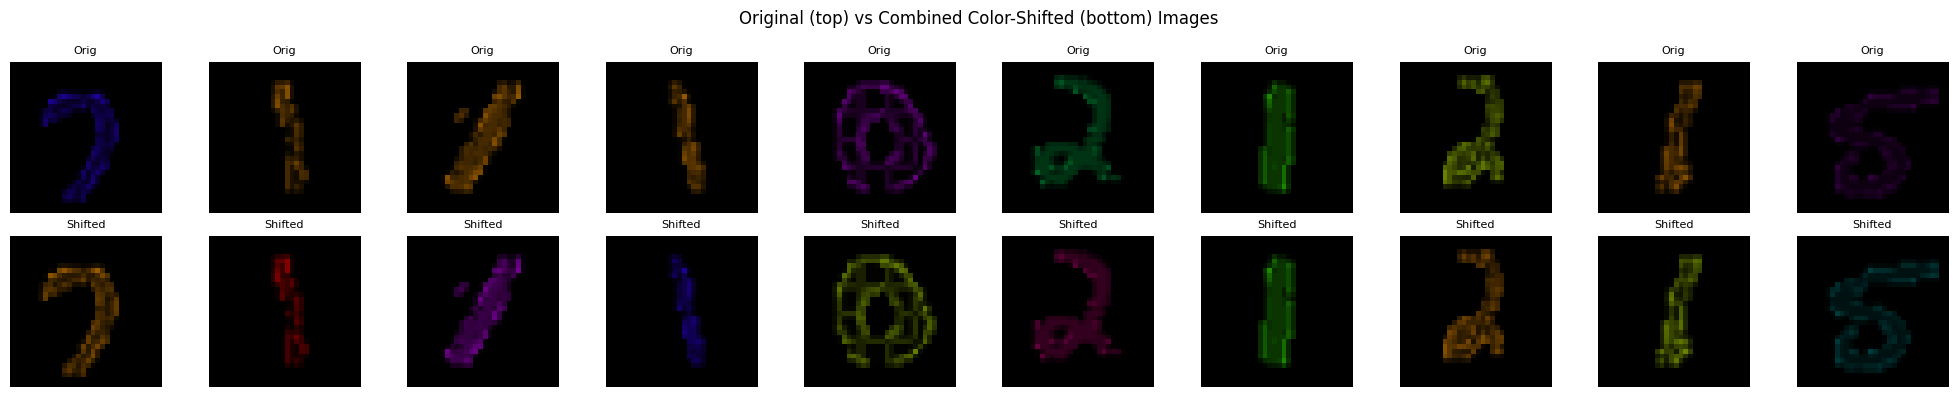

In [76]:
def apply_color_to_digit(digit_img, color_onehot, color_palette):
    if digit_img.ndim == 1:
        digit_img = digit_img.reshape(32, 32, 3)
    digit_mask = digit_img.mean(axis=2)  # (32, 32)
    color_rgb = color_palette[np.argmax(color_onehot)]
    img_colored = np.zeros_like(digit_img)
    for c in range(3):
        img_colored[:, :, c] = digit_mask * color_rgb[c]
    return img_colored

K = 10
plt.figure(figsize=(2 * K, 4))
for idx in range(K):
    plt.subplot(2, K, idx + 1)
    orig_img = Dll_obs[idx, :3072].reshape(32, 32, 3)
    orig_colored = apply_color_to_digit(orig_img, color_onehotL[idx], color_palette)
    plt.imshow(np.clip(orig_colored, 0, 1))
    plt.axis('off')
    plt.title(f"Orig", fontsize=8)

    plt.subplot(2, K, K + idx + 1)
    shifted_colored = apply_color_to_digit(orig_img, color_onehotL_combined[idx], color_palette)
    plt.imshow(np.clip(shifted_colored, 0, 1))
    plt.axis('off')
    plt.title(f"Shifted", fontsize=8)
plt.suptitle("Original (top) vs Combined Color-Shifted (bottom) Images")
plt.tight_layout()
plt.show()

## Digit shift

In [77]:
num_samples = digit_onehotL.shape[0]
num_digits = digit_onehotL.shape[1]
original_digits = np.argmax(digit_onehotL, axis=1)

digit_onehotL_combined = digit_onehotL.copy()
shuffled_indices = np.random.permutation(num_samples)
for idx in range(num_samples):
    if np.random.rand() < 0.5:
        # Shuffle: assign digit from another sample
        digit_onehotL_combined[idx] = digit_onehotL[shuffled_indices[idx]]
    else:
        # Random: assign a random digit (not the original)
        orig_d = original_digits[idx]
        possible_digits = list(set(range(num_digits)) - {orig_d})
        new_d = np.random.choice(possible_digits)
        digit_onehotL_combined[idx] = 0
        digit_onehotL_combined[idx, new_d] = 1

results_digit_combined = compute_errors_new(
    T_results_emp=T_results_emp,
    Ill_relevant=Ill_relevant,
    det_ll_dict=det_ll_dict_test,
    det_hl_dict=det_hl_dict_test,
    digit_onehotL=digit_onehotL_combined,
    color_onehotL=color_onehotL,
    digit_onehotH=digit_onehotH,
    color_onehotH=color_onehotH,
    omega=omega,
    base_noise_L=U_L,
    base_noise_H=U_H,
    shift=False,
    r_mu=0.0,
    r_sigma=0.0,
    mean_shift=0.0,
    direction=True,
    num_perturbations=1
)

print("Results under COMBINED random+shuffle digit shift:")
for method, vals in results_digit_combined.items():
    print(f"{method}: mean error = {np.mean(vals):.4f}")

Results under COMBINED random+shuffle digit shift:
T_100: mean error = 91.4838
T_30: mean error = 48.8195
T_8: mean error = 24.0103
T_4: mean error = 23.5111
T_0.188-0.188: mean error = 20.6908
T_2: mean error = 26.2735
T_1: mean error = 23.7696
T_pa: mean error = 22.8940
T_na: mean error = 22.0463
T_0.00: mean error = 288.2260
T_s: mean error = 142.8559
T_b: mean error = 355.4713


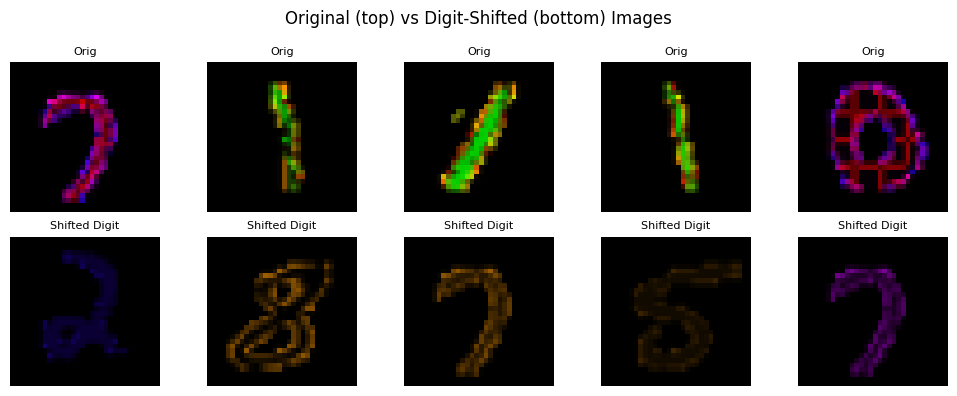

In [78]:
K = 5 

plt.figure(figsize=(2 * K, 4))
for idx in range(K):
    # Original image
    plt.subplot(2, K, idx + 1)
    orig_img = Dll_obs[idx, :3072].reshape(32, 32, 3)
    plt.imshow(np.clip(orig_img, 0, 1))
    plt.axis('off')
    plt.title("Orig", fontsize=8)
    
    # Shifted digit image (from shifted one-hot, colorized with original color)
    shifted_digit_label = np.argmax(digit_onehotL_combined[idx])
    # Find a sample with that digit label
    mask_idx = np.where(np.argmax(digit_onehotL, axis=1) == shifted_digit_label)[0][0]
    digit_mask = Dll_obs[mask_idx, :3072].reshape(32, 32, 3).mean(axis=2)
    color_rgb = color_palette[np.argmax(color_onehotL[idx])]
    img_colored = np.zeros((32, 32, 3))
    for c in range(3):
        img_colored[:, :, c] = digit_mask * color_rgb[c]
    plt.subplot(2, K, K + idx + 1)
    plt.imshow(np.clip(img_colored, 0, 1))
    plt.axis('off')
    plt.title("Shifted Digit", fontsize=8)

plt.suptitle("Original (top) vs Digit-Shifted (bottom) Images")
plt.tight_layout()
plt.show()

In [61]:
def get_digit_image_from_onehot(digit_onehot, mnist_images, mnist_labels):
    """
    digit_onehot: (10,) one-hot vector for the digit
    mnist_images: (N, 32, 32, 3) or (N, 3072) array of images
    mnist_labels: (N,) array of digit labels (0-9)
    Returns: (32, 32, 3) image of the requested digit
    """
    digit_label = np.argmax(digit_onehot)
    # Find the first image with this label
    idx = np.where(mnist_labels == digit_label)[0][0]
    img = mnist_images[idx]
    if img.ndim == 1:
        img = img.reshape(32, 32, 3)
    return img

In [62]:
# Suppose you have mnist_images (N, 3072) and mnist_labels (N,)
for idx in range(K):
    shifted_img = get_digit_image_from_onehot(digit_onehotL_combined[idx], mnist_images, mnist_labels)
    # You can then colorize this image as before using your color_onehotL or color_onehotL_combined

NameError: name 'mnist_images' is not defined

In [ ]:
def get_digit_mask_from_onehot(digit_onehot, digit_masks):
    """
    digit_onehot: (10,) one-hot vector for the digit
    digit_masks: (10, 32, 32) array, one mask per digit
    Returns: (32, 32) mask for the requested digit
    """
    digit_label = np.argmax(digit_onehot)
    return digit_masks[digit_label]

In [ ]:
for idx in range(K):
    # Get the digit image for the shifted digit one-hot
    digit_img = get_digit_image_from_onehot(digit_onehotL_combined[idx], mnist_images, mnist_labels)
    # Colorize using the (possibly shifted) color one-hot
    colored_img = apply_color_to_digit(digit_img, color_onehotL[idx], color_palette)
    plt.imshow(np.clip(colored_img, 0, 1))
    # ...

In [63]:
def get_digit_image_from_onehot(digit_onehot, images, labels):
    digit_label = np.argmax(digit_onehot)
    idx = np.where(labels == digit_label)[0][0]
    img = images[idx]
    if img.ndim == 1:
        img = img.reshape(32, 32, 3)
    return img

# Example usage:
for idx in range(K):
    shifted_img = get_digit_image_from_onehot(digit_onehotL_combined[idx], Dll_obs, digit_labels)
    # Now you can colorize or display shifted_img

NameError: name 'digit_labels' is not defined

In [64]:
digit_labels = np.argmax(digit_onehotL, axis=1)

In [66]:
def get_digit_image_from_onehot(digit_onehot, images, labels):
    digit_label = np.argmax(digit_onehot)
    idx = np.where(labels == digit_label)[0][0]
    img = images[idx][:3072]  # Only use the pixel part!
    img = img.reshape(32, 32, 3)
    return img

digit_labels = np.argmax(digit_onehotL, axis=1)

# Example usage:
for idx in range(K):
    shifted_img = get_digit_image_from_onehot(digit_onehotL_combined[idx], Dll_obs, digit_labels)
    # Now you can colorize or display shifted_img

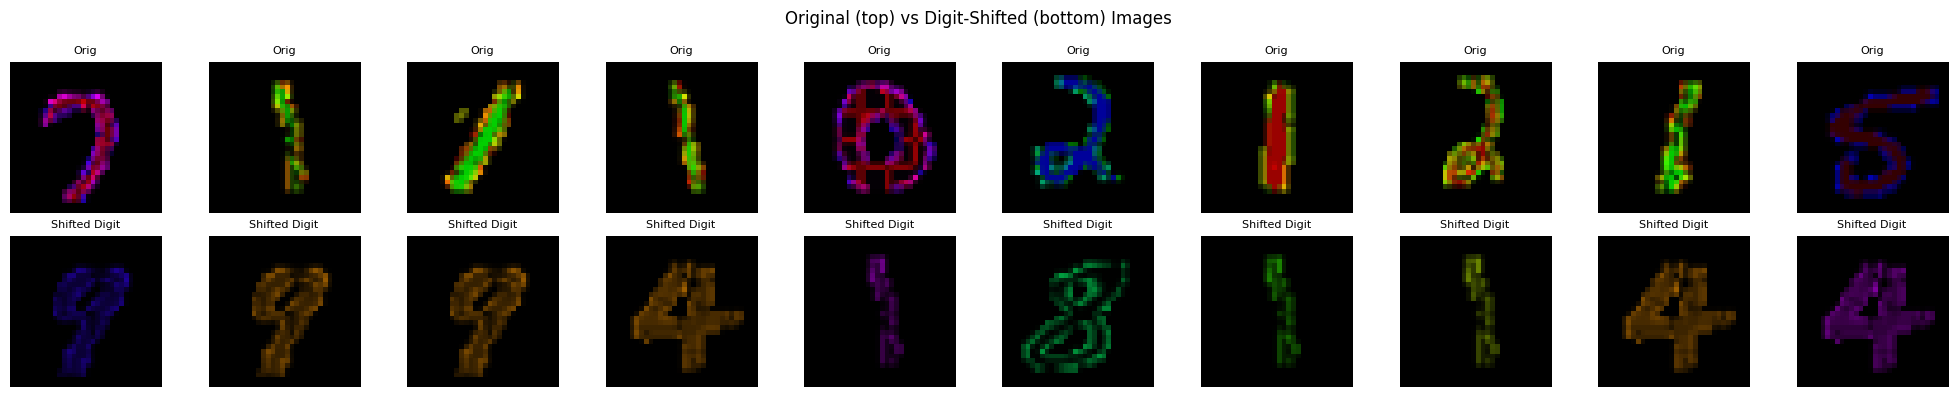

In [67]:
K = 5  # Number of samples to visualize

plt.figure(figsize=(2 * K, 4))
for idx in range(K):
    # Original image (from Dll_obs)
    plt.subplot(2, K, idx + 1)
    orig_img = Dll_obs[idx, :3072].reshape(32, 32, 3)
    plt.imshow(np.clip(orig_img, 0, 1))
    plt.axis('off')
    plt.title("Orig", fontsize=8)
    
    # Shifted digit image (from shifted one-hot)
    shifted_img = get_digit_image_from_onehot(digit_onehotL_combined[idx], Dll_obs, digit_labels)
    # If you want to colorize with the original color:
    shifted_colored = apply_color_to_digit(shifted_img, color_onehotL[idx], color_palette)
    plt.subplot(2, K, K + idx + 1)
    plt.imshow(np.clip(shifted_colored, 0, 1))
    plt.axis('off')
    plt.title("Shifted Digit", fontsize=8)

plt.suptitle("Original (top) vs Digit-Shifted (bottom) Images")
plt.tight_layout()
plt.show()

In [73]:
results_digit_shift = compute_errors_new(
    T_results_emp=T_results_emp,
    Ill_relevant=Ill_relevant,
    det_ll_dict=det_ll_dict_test,
    det_hl_dict=det_hl_dict_test,
    digit_onehotL=digit_onehotL_combined,  # <--- shifted digits!
    color_onehotL=color_onehotL,           # keep original colors
    digit_onehotH=digit_onehotH,
    color_onehotH=color_onehotH,
    omega=omega,
    base_noise_L=U_L,
    base_noise_H=U_H,
    shift=False,
    r_mu=0.0,
    r_sigma=0.0,
    mean_shift=0.0,
    direction=True,
    num_perturbations=1
)

In [74]:
print("Results under DIGIT shift:")
for method, vals in results_digit_shift.items():
    print(f"{method}: mean error = {np.mean(vals):.4f}")

Results under DIGIT shift:
T_100: mean error = 92.4241
T_30: mean error = 49.3942
T_8: mean error = 24.0537
T_4: mean error = 23.2308
T_0.188-0.188: mean error = 20.5278
T_2: mean error = 26.2118
T_1: mean error = 23.3544
T_pa: mean error = 22.8528
T_na: mean error = 22.0187
T_0.00: mean error = 287.6924
T_s: mean error = 143.7145
T_b: mean error = 355.3585


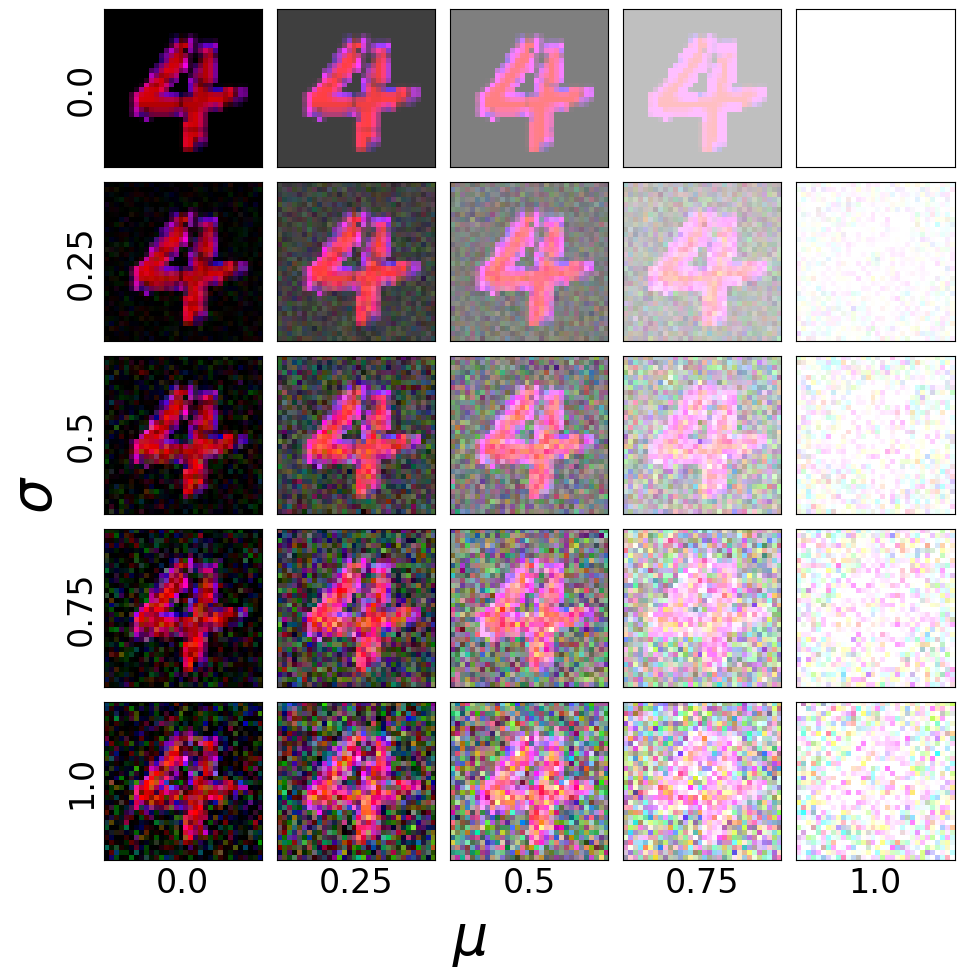

In [33]:
i = 10 #10, 25
img_vec = Dll_obs[i, :3072]
img_vec = img_vec.reshape(-1)

# Define a grid of perturbation strengths
mean_shift_vals = np.linspace(0, 1, 5)
r_sigma_vals = np.linspace(0, 1, 5)

# Generate perturbed vector
def generate_perturbed_image(base_vec, mean_shift, r_sigma):
    pert_mean = np.ones_like(base_vec) * mean_shift
    pert_cov = np.random.randn(*base_vec.shape)
    pert_cov = r_sigma * pert_cov / np.linalg.norm(pert_cov) * np.linalg.norm(base_vec)
    return base_vec + pert_mean + pert_cov

# Plotting
fig, axarr = plt.subplots(len(r_sigma_vals), len(mean_shift_vals), figsize=(10, 10))

for i, r_sigma in enumerate(r_sigma_vals):         # Rows = sigma
    for j, mean_shift in enumerate(mean_shift_vals):  # Cols = mean
        perturbed = generate_perturbed_image(img_vec, mean_shift, r_sigma)
        img = perturbed.reshape(32, 32, 3)
        img = np.clip(img, 0, 1)

        ax = axarr[i, j]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        # Column tick labels (bottom row only)
        if i == len(r_sigma_vals) - 1:
            ax.set_xlabel(f"{mean_shift}", fontsize=24)
        # Row tick labels (leftmost column only)
        if j == 0:
            ax.set_ylabel(f"{r_sigma}", fontsize=24)

# Add central axis labels
fig.text(0.5, 0.04, r'$\mu$', ha='center', fontsize=40)
fig.text(0.04, 0.5, r'$\sigma$', va='center', rotation='vertical', fontsize=40)

plt.tight_layout(rect=[0.08, 0.08, 1, 1])  # adjust to make room for axis labels
plt.show()


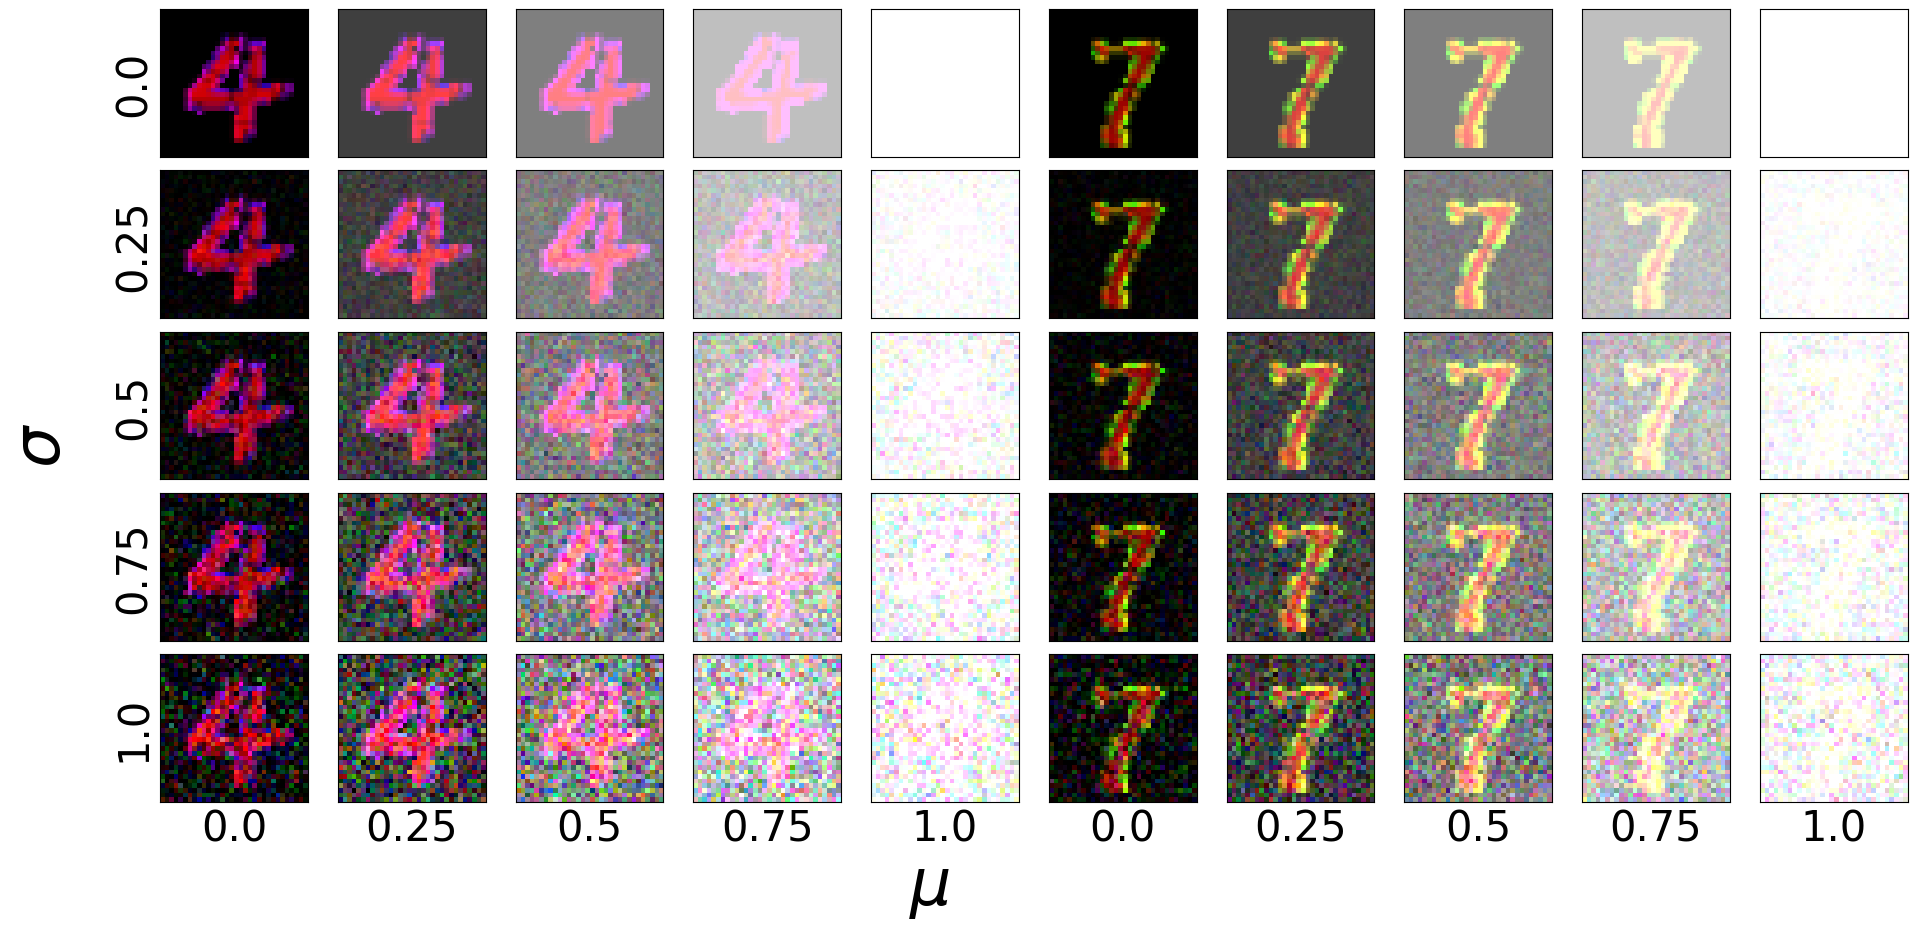

In [78]:
mean_shift_vals = [0.0, 0.25, 0.5, 0.75, 1.0]  # X-axis
r_sigma_vals = [0.0, 0.25, 0.5, 0.75, 1.0]     # Y-axis
image_indices = [10, 25]  # Two images to compare side-by-side

# Perturbation generator
def generate_perturbed_image(base_vec, mean_shift, r_sigma):
    pert_mean = np.ones_like(base_vec) * mean_shift
    pert_cov = np.random.randn(*base_vec.shape)
    pert_cov = r_sigma * pert_cov / np.linalg.norm(pert_cov) * np.linalg.norm(base_vec)
    return base_vec + pert_mean + pert_cov

# Plot grid
fig, axarr = plt.subplots(len(r_sigma_vals), len(mean_shift_vals) * len(image_indices), figsize=(20, 10))

for img_block, i in enumerate(image_indices):
    img_vec = Dll_obs[i, :3072].reshape(-1)

    for row, r_sigma in enumerate(r_sigma_vals):
        for col, mean_shift in enumerate(mean_shift_vals):
            ax_idx = col + img_block * len(mean_shift_vals)
            ax = axarr[row, ax_idx]
            
            perturbed = generate_perturbed_image(img_vec, mean_shift, r_sigma)
            img = perturbed.reshape(32, 32, 3)
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])

            # Only label mu on bottom row
            if row == len(r_sigma_vals) - 1:
                ax.set_xlabel(f"{mean_shift}", fontsize=30)
            # Only label sigma for the first image block
            if col == 0 and img_block == 0:
                ax.set_ylabel(f"{r_sigma}", fontsize=30)

# Add shared axis labels
fig.text(0.5, 0.04, r'$\mu$', ha='center', fontsize=47)
fig.text(0.04, 0.5, r'$\sigma$', va='center', rotation='vertical', fontsize=47)

# Add image titles above each block
for block_idx, img_idx in enumerate(image_indices):
    col_start = block_idx * len(mean_shift_vals)
    center = col_start + len(mean_shift_vals) / 2 - 0.5
    # fig.text(center / (len(image_indices) * len(mean_shift_vals)), 0.98,
    #          f"Image index {img_idx}", ha='center', fontsize=14)

plt.tight_layout(rect=[0.08, 0.08, 1, 0.95])
plt.show()

